In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
!pip install --quiet git+https://github.com/theislab/scgen.git

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/anndata/_core/anndata.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy import sparse


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/matplotlib_inline/config.py:54: DeprecationWarning: InlineBackend._print_figure_kwargs_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _update_figure_formatters(self):


### Import the metric -- scib

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install --quiet scib
import scib

In [ ]:
!pip install --quiet louvain
import louvain

## Import the data

In [6]:
import anndata
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [4]:
# # Renaming the 'celltype' column to 'cell_type'
# adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)

# # Replacing the 'batch' column with the values from 'BATCH'
# # Assuming 'BATCH' exists in the DataFrame
# adata.obs['batch'] = adata.obs['sample']

In [32]:
# import pandas as pd

# # Create a new DataFrame for the `var` metadata
# new_var = pd.DataFrame(index=adata.var_names)

# # Populate the DataFrame with some example metadata
# # For example, let's just create a column named 'gene_name' with the same names as index
# new_var['gene_name'] = adata.var_names

# # Assign this DataFrame to adata.var
# adata.var = new_var

# # Verify the changes
# print(adata.var.head())

                 gene_name
index                     
ZNF692              ZNF692
ZNF672_p          ZNF672_p
SH3BP5L            SH3BP5L
LOC102117280  LOC102117280
LYPD8                LYPD8


In [5]:
# adata.write_h5ad('../macaque_raw.h5ad')

In [8]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [9]:
# preprocessing
import scanpy as sc

adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Assuming 'vae' is your trained model
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [18]:
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [19]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

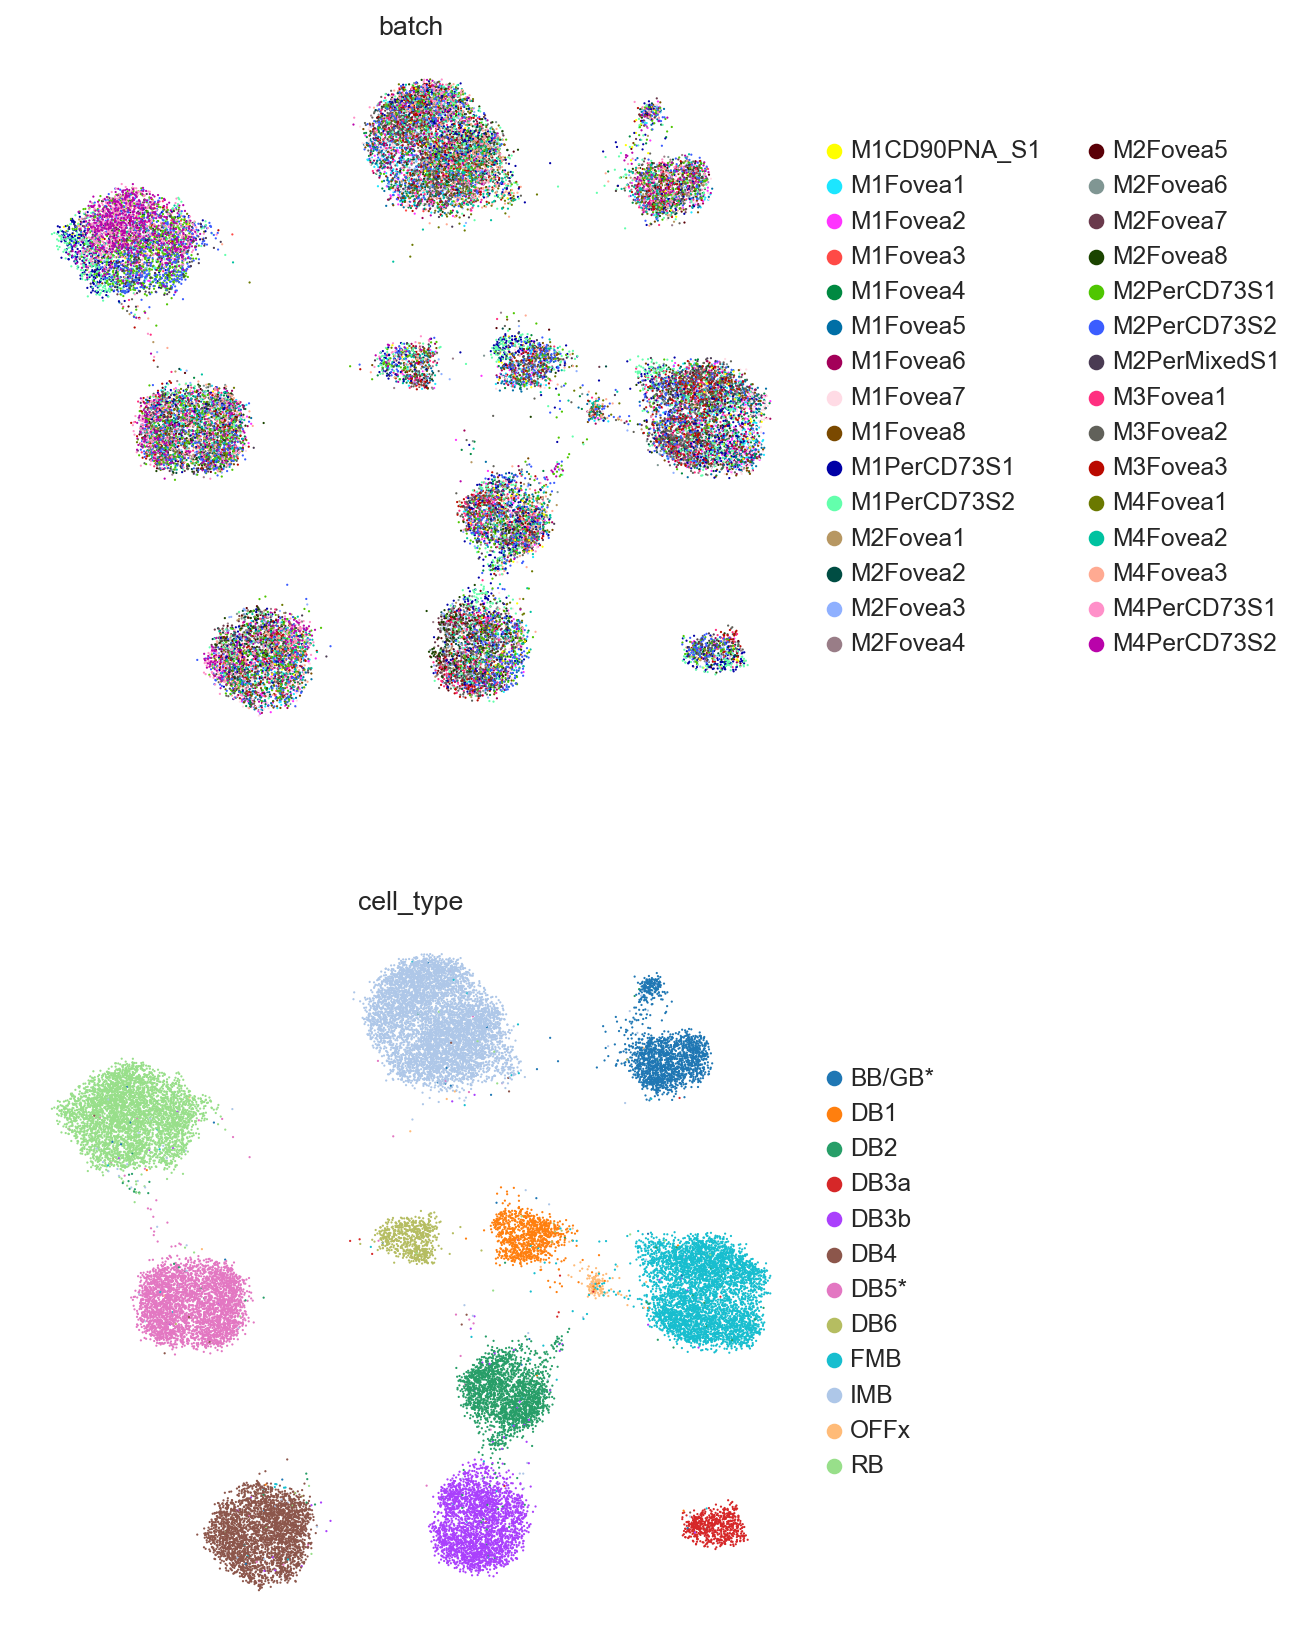

In [20]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [21]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

In [22]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [16:32<00:00, 49.79s/it, v_num=1, train_loss_step=417

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [16:32<00:00, 49.64s/it, v_num=1, train_loss_step=417


In [23]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [24]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [25]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

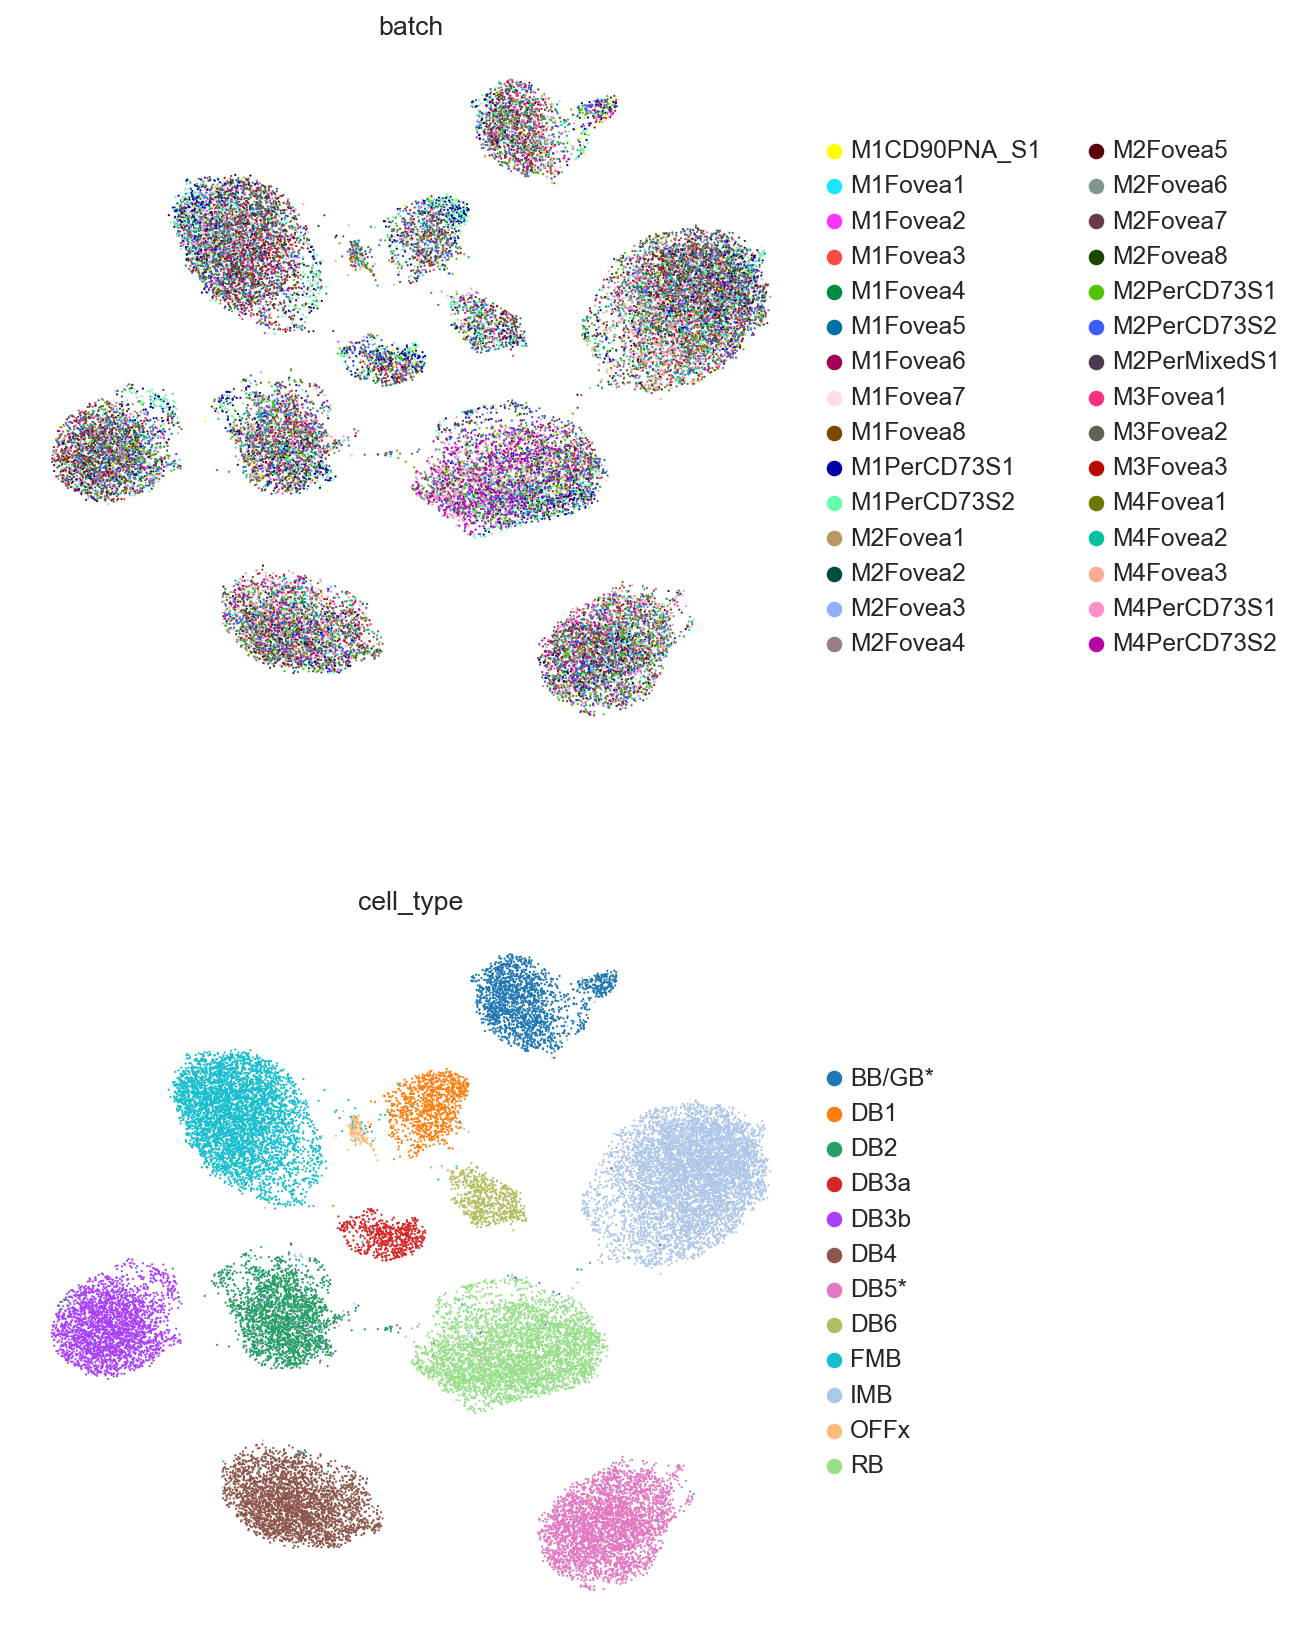

In [26]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [11]:
train = adata.copy()

### Preprocessing Data

In [12]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="cell_type")

## Creating and Training the model¶

In [13]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|▎| 26/100 [07:25<21:07, 17.13s/it, v_num=1, train_loss_step=1
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1016.379. Signaling Trainer to stop.


## Batch-Removal

In [14]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [15]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [16]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

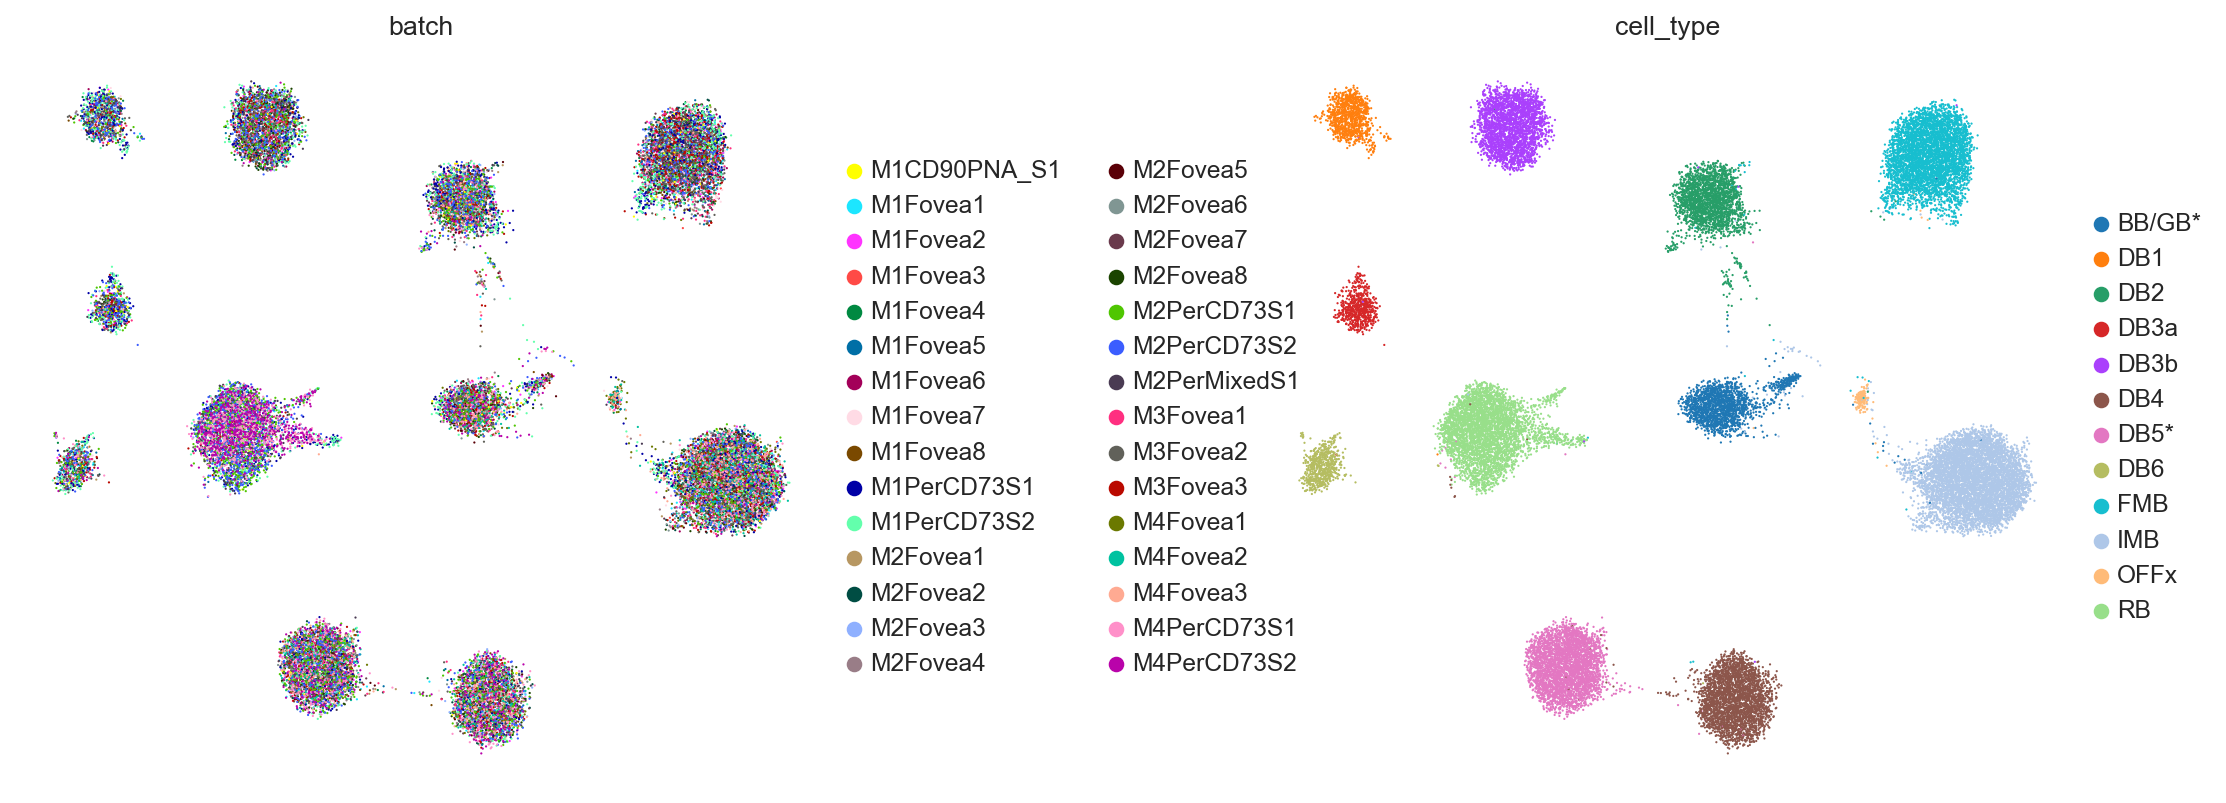

In [17]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [27]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_stacas_embeddings_full_labels.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [28]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

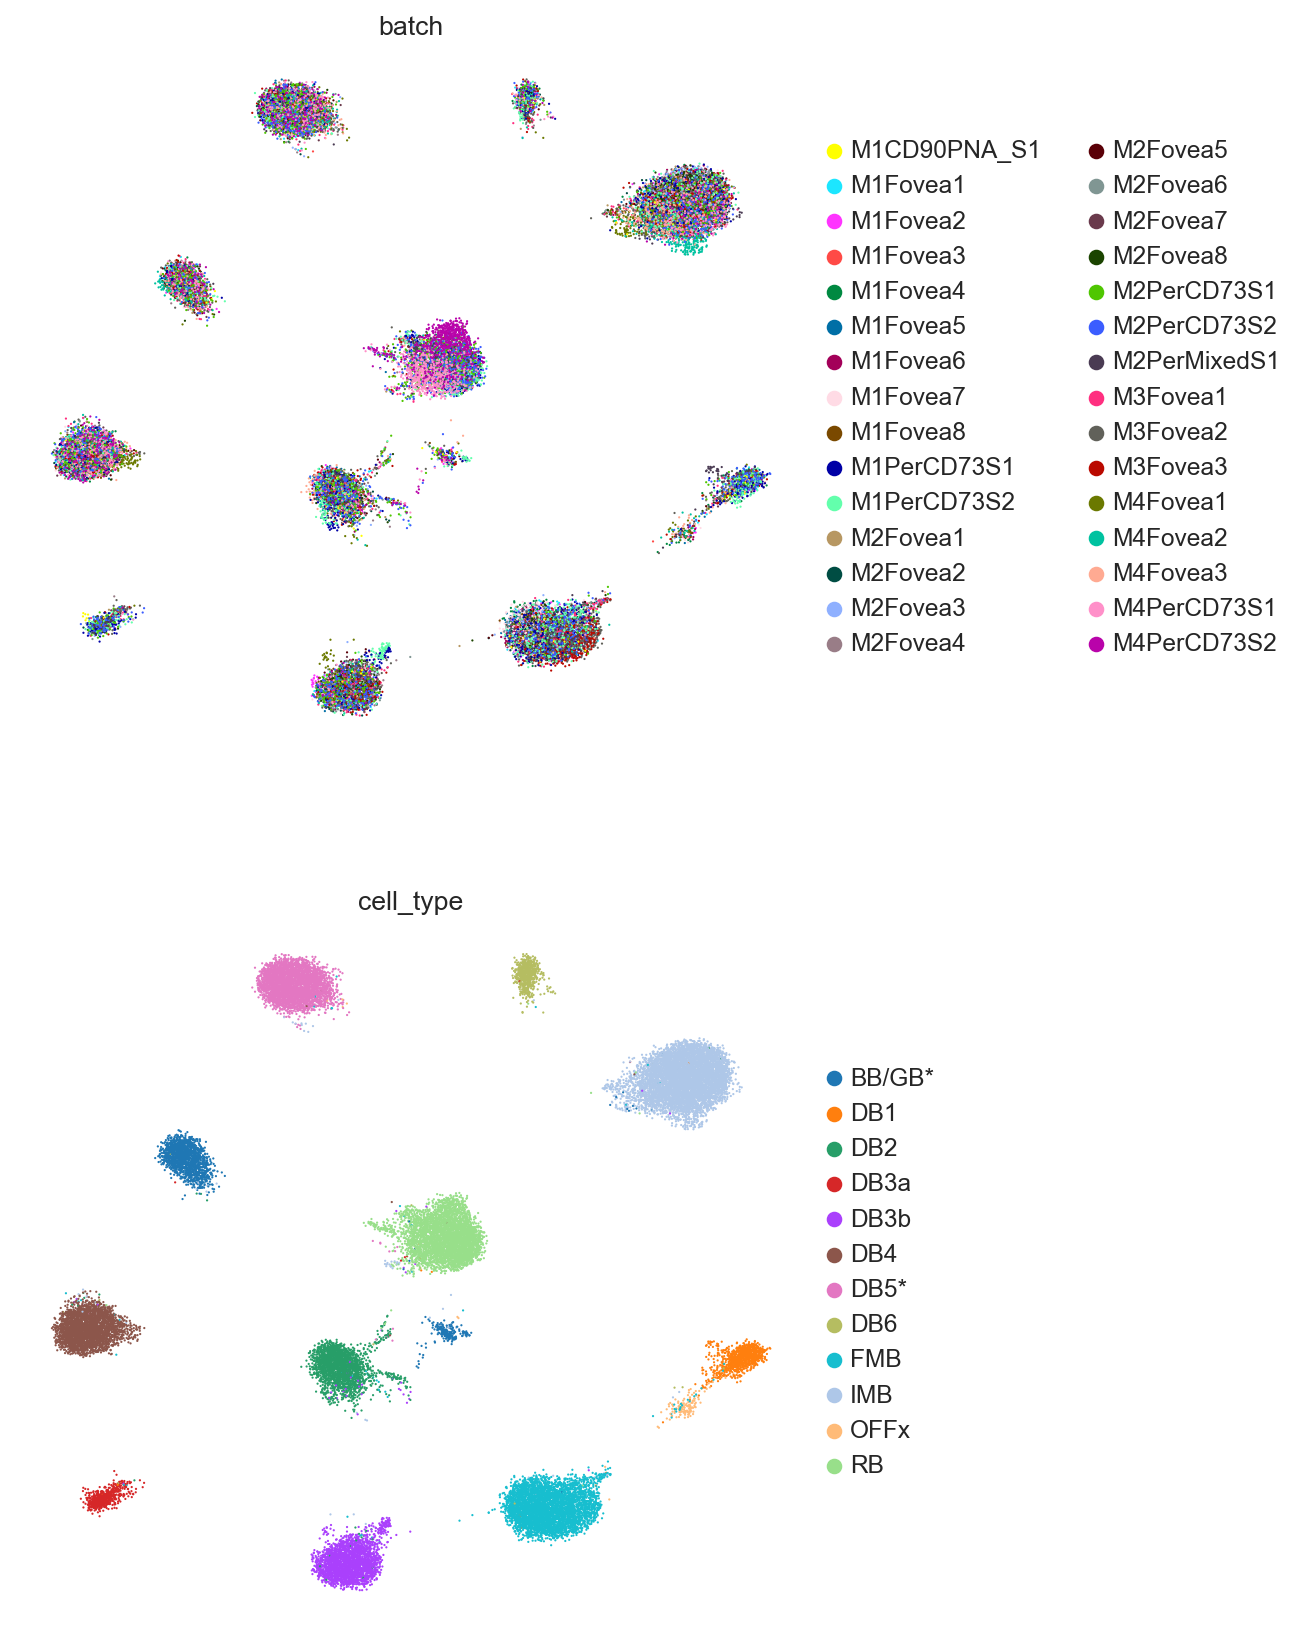

In [29]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [30]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/full_annotated_supervised_macaque.csv")


# Metric Evaluation

## read the embeddings

In [63]:
# Step 1: Read the CSV file into a DataFrame
import pandas as pd

combined_embeddings = pd.read_csv("../embeddings/full_annotated_supervised_macaque.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [64]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.9718546496433345
resolution: 0.2, nmi: 0.9396963247858152
resolution: 0.3, nmi: 0.906088003900698
resolution: 0.4, nmi: 0.9060613857503003
resolution: 0.5, nmi: 0.9079769936443944
resolution: 0.6, nmi: 0.9045753887929759
resolution: 0.7, nmi: 0.8971832767893136
resolution: 0.8, nmi: 0.8892057106706533
resolution: 0.9, nmi: 0.8921579354402706
resolution: 1.0, nmi: 0.8874390476810683
resolution: 1.1, nmi: 0.88627916150623
resolution: 1.2, nmi: 0.8779441230139609
resolution: 1.3, nmi: 0.8702411119693976
resolution: 1.4, nmi: 0.8658951900568965
resolution: 1.5, nmi: 0.8605837712951098
resolution: 1.6, nmi: 0.8334320989267224
resolution: 1.7, nmi: 0.8328062135527377
resolution: 1.8, nmi: 0.8275983129927958
resolution: 1.9, nmi: 0.8237425938768302
resolution: 2.0, nmi: 0.8235806518632222
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9718546496433345
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [65]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.8837583995129932
resolution: 0.2, nmi: 0.9002236379873658
resolution: 0.3, nmi: 0.8969507544625724
resolution: 0.4, nmi: 0.8916734319930295
resolution: 0.5, nmi: 0.9059740612333222
resolution: 0.6, nmi: 0.9061519067985467
resolution: 0.7, nmi: 0.9102381109380039
resolution: 0.8, nmi: 0.9102242164876398
resolution: 0.9, nmi: 0.9096970982687445
resolution: 1.0, nmi: 0.8993118069177628
resolution: 1.1, nmi: 0.9044970443755498
resolution: 1.2, nmi: 0.9024132374970509
resolution: 1.3, nmi: 0.8942310962823941
resolution: 1.4, nmi: 0.8780631567310566
resolution: 1.5, nmi: 0.8550709292107708
resolution: 1.6, nmi: 0.8514762717041456
resolution: 1.7, nmi: 0.8519061603735274
resolution: 1.8, nmi: 0.8517600362210057
resolution: 1.9, nmi: 0.8389511015902446
resolution: 2.0, nmi: 0.8443166278106442
optimised clustering against cell_type
optimal cluster resolution: 0.7
optimal score: 0.9102381109380039
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors o

In [67]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.9504895717578699
resolution: 0.2, nmi: 0.9409628636715615
resolution: 0.3, nmi: 0.9209483862141689
resolution: 0.4, nmi: 0.885612715697062
resolution: 0.5, nmi: 0.881541802159198
resolution: 0.6, nmi: 0.8737247348770893
resolution: 0.7, nmi: 0.873321560687682
resolution: 0.8, nmi: 0.8520822533081613
resolution: 0.9, nmi: 0.8296169951227168
resolution: 1.0, nmi: 0.8234008996206256
resolution: 1.1, nmi: 0.8184490428629927
resolution: 1.2, nmi: 0.8182601355380953
resolution: 1.3, nmi: 0.8215886840483093
resolution: 1.4, nmi: 0.8199075725031968
resolution: 1.5, nmi: 0.8151849686648251
resolution: 1.6, nmi: 0.8148808114603744
resolution: 1.7, nmi: 0.8090316115752471
resolution: 1.8, nmi: 0.8090595980351852
resolution: 1.9, nmi: 0.8045538220388694
resolution: 2.0, nmi: 0.8024258378220273
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.9504895717578699
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [68]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/macaque_metrics_supervised_full.csv", index=True)

In [69]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.973056,0.915765,0.944892
ARI_cluster/label,0.983207,0.904490,0.959481
ASW_label,0.682697,0.552279,0.624752
ASW_label/batch,0.933642,0.930156,0.926031
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.986623,0.964569,0.967532
isolated_label_silhouette,0.679203,0.557765,0.619550
graph_conn,0.998164,0.995067,0.992016
kBET,NaN,NaN,NaN
